In [ ]:
!echo 'Mounting...'
from google.colab import drive
drive.mount('drive')
!ls 'dir'
!echo 'Mounted'

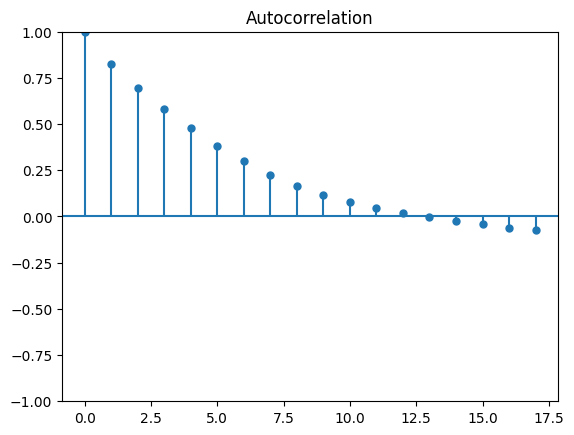

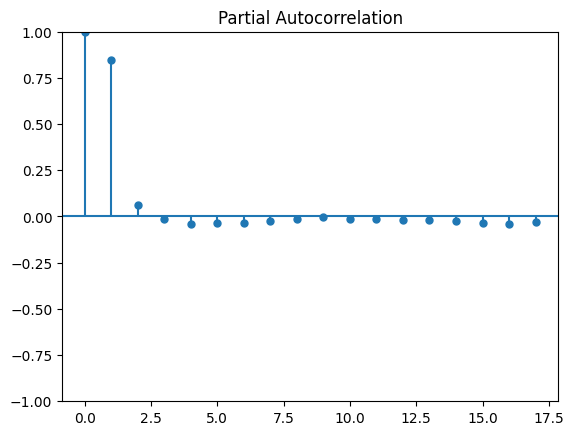

ADF Statistic: -24.729309
p-value: 0.000000
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-57869.355, Time=4.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-10370.727, Time=1.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-49198.271, Time=1.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-21967.443, Time=1.96 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13878.358, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-56867.490, Time=2.62 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-57921.008, Time=3.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-54948.108, Time=4.25 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-57887.577, Time=3.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-57820.847, Time=2.79 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-57925.300, Time=3.48 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-57925.649, Time=6.16 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-57958.569, Time=4.59 sec
 ARIMA(5,0,1)(0,0,0)[0] interc

In [2]:
#@title ARIMA
import statsmodels.tsa.api as tsa
import numpy as np
from patsy import dmatrices
from numpy import hstack
from numpy import sum

np.random.seed(1)

import pandas as pd
from matplotlib import pyplot
from numpy import array
from sklearn import preprocessing
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import concatenate
from scipy.stats import boxcox
from math import exp
from math import log
from numpy import mean
import copy
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from pandas import concat
from math import exp
from math import log
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array
import pickle
# %matplotlib inline

##!pip install pmdarima
from pandas.plotting import lag_plot
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import numpy as np

# invert a boxcox transform for one value
def invert_boxcox(value, lam):
    # log case
    if lam == 0:
        return exp(value)
    # all other cases
    return exp(log(lam * value + 1) / lam)

#Load county data
mydata = pd.read_csv('nas.csv', header=0)
dataIn = mydata[mydata.columns[1:8]]
dateT = mydata[mydata.columns[0]]
dateT = DataFrame(dateT)
dateT['dateTime'] = dateT
dateT.drop('Unnamed: 0', axis = 1, inplace = True)
df_data = pd.concat((dateT, dataIn), axis=1)
df_data = df_data.drop(df_data.columns[0], axis = 1)

# Drop rows which contain any NaN values in all columns
df_data = df_data.dropna( how='all')

# Interpolate missing values
df_data = df_data.interpolate(method ='linear', limit_direction ='both', limit = 10000, axis=0)

# move target variable to the last column to align with surpervise learning struture
finData = pd.DataFrame(df_data,columns=['Temp','Preci','Gust','Wind','Windir','LAI','Total Outages'])

# Compute an auto-correlation plots
X = pm.acf(finData['Total Outages'])
# Plot an auto-correlation:
pm.plot_acf(X)
pm.plot_pacf(X)

# Check for stionarity
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(finData['Total Outages'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Split into train and test set
train_size = int(len(finData) * 0.80)
train_data, test_data = finData.iloc[0:train_size], finData.iloc[train_size:]

# Create input/output samples for estimation of model parameters
x_train,y_train = train_data.iloc[:,:-1],train_data.iloc[:,-1]
x_test,y_test = test_data.iloc[:,:-1],test_data.iloc[:,-1]

# BoxCox Power Transform on train data
box_power_train = y_train
transformed_train, lmbda = boxcox(box_power_train)
df_trans_train = np.array(transformed_train)
y_trans_train = df_trans_train.reshape(-1,1)

# Apply lamda to test data
box_power_test = y_test
transformed_test = boxcox(box_power_test,lmbda)
df_trans_test = np.array(transformed_test)
y_trans_test = df_trans_test.reshape(-1,1)

# 6 Rolling Mean on train data
dwAvg = 6
y_train_mean = pd.DataFrame(y_trans_train)
y_train_mean = y_train_mean.rolling(dwAvg).mean()
y_train_mean = y_train_mean.interpolate(method ='linear', limit_direction ='both', limit = 100, axis=0)

# Test fold
y_test_mean = pd.DataFrame(y_trans_test)
y_test_mean = y_test_mean.rolling(dwAvg).mean()
y_test_mean = y_test_mean.interpolate(method ='linear', limit_direction ='both', limit = 100, axis=0)

# Scaling
# Train
X_scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_data = X_scaler.fit_transform(x_train)
Y_train_scaled_data = Y_scaler.fit_transform(y_train_mean)
# Test
X_test_scaled_data = X_scaler.transform(x_test)
Y_test_scaled_data = Y_scaler.transform(y_test_mean)

# Estimate hyper-parameters on raw train data
auto_n = auto_arima(Y_train_scaled_data,suppress_warnings=True,seasonal=True,
                     stepwise=True,error_action="ignore", max_p=5,maxiter=10,method='nm',
                     max_order=None, trace=True,stationary=True)
print(auto_n.summary())

import pickle
# Save model and list objects
with open('file','wb') as f:
    pickle.dump(auto_n,f)

In [ ]:
# load saved objects
with open('source_file','rb') as f:
    mp = pickle.load(f)

# Prepare test data
start = 0
lag = 6 # look back
h = 1   # forecast horizon

y_te_input= list()
y_te_output= list()
predictions = list()

y_target = Y_test_scaled_data
y_target_value = y_target


# Update model and make forecast
end = None
start = start + lag
if end is None:
    end = len(y_test) - h
for j in range(start, end):
    indices_j = range(j-lag, j)
    y_tes_input = y_target_value[indices_j]
    mp.update(y_tes_input)
    indicey_j = range(j+1, j+1+h)
    y_tes_output = y_target_value[indicey_j]
    y_te_output.append(y_tes_output[-1])
    new_preds, new_conf_int = mp.predict(n_periods=len(y_tes_output),return_conf_int=True)
    predictions.append(new_preds[-1])

# Compute test scores
yhat = np.array(predictions)
y_last_h = yhat.reshape(-1,1)
# Inverse scale of forecast values
pred_Inverse = Y_scaler.inverse_transform(y_last_h)
# Inverse power transform of forecast values
y_b_inv = [invert_boxcox(x, lmbda) for x in pred_Inverse]
y_b_inv = np.array(y_b_inv)

y_ac = np.array(y_te_output)
y_actual = y_ac.reshape(-1,1)
# Inverse scale of actual values
actual_Inverse = Y_scaler.inverse_transform(y_actual)
# Inverse power transform of actual values
y_actual_inv = [invert_boxcox(x, lmbda) for x in actual_Inverse]
y_actual_inv = np.array(y_actual_inv)

pred = y_b_inv
actual = y_actual_inv

mse = mean_squared_error(actual, pred)
# calculate rmse
rmse = sqrt(mse)
# print rmse
print('Average Test RMSE: %.3f' % (rmse))

# Visualizations
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.tight_layout(pad=6.0)

axes[0].set_title("Actual & forecasted test samples")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Customer Outages")

real = DataFrame(actual)
real = real.values

x_axis = np.arange(train_data.shape[0] + pred.shape[0])
axes[0].plot(x_axis[:train_data.shape[0]], train_data, alpha=0.75,label='Train Data')
axes[0].legend(loc="upper right")
axes[0].scatter(x_axis[train_data.shape[0]:], pred, alpha=0.4, marker='o',label='Forecast')
axes[0].legend(loc="upper right")
axes[0].scatter(x_axis[train_data.shape[0]:], actual, alpha=0.4, marker='x',label='Test Data')
axes[0].legend(loc="upper right")

new_x_axis = np.arange(len(actual))
axes[1].plot(new_x_axis[:300], real[:300], alpha=0.75,label='Actual',color='blue')
axes[1].legend(loc="upper right")
axes[1].plot(new_x_axis[:300], pred[:300], alpha=0.75,label='Predicted',color='red')
axes[1].legend(loc="upper right")
axes[1].set_title("Actual & forecasted test samples:First 300 time steps in expanded view")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Customer Outages")
plt.show()